In [941]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import time
from torchvision import datasets
import matplotlib.pyplot as plt  # This is python's popular plotting library.
# This is to ensure matplotlib plots inline and does not try to open a new window.
%matplotlib inline  
from collections import OrderedDict

In [910]:
import torch.nn.utils.prune as prune
import pandas as  pd

In [911]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)


In [912]:
# get the data
trainset = datasets.MNIST(
    root = './data',
    train = True,
    download = False, 
    transform = transform
)
testset = datasets.MNIST(
    root = './data',
    train = False,
    download = False,
    transform = transform
)
testloader = DataLoader(
    testset, 
    batch_size = 4,
    shuffle = False
)

In [913]:
# extract a subset of the digits as local client data
# local_client_digits = [0,1,2,7,9]
# local_client_digits = [3,4,5,6,8]
local_client_digits = [0,1,2,3,4,5,6,7,8,9]
idx = []
for i in local_client_digits:
    idx_i = (trainset.targets == i).nonzero()[:,0].tolist()
    print("digit %d: %d samples" %(i, len(idx_i)))
    idx += idx_i

print("number of selected data = {}".format(len(idx)))
# selected_data = trainset.data[idx].unsqueeze(1)
# print(selected_data.shape)
# selected_labels = trainset.targets[idx]
# selected_trainset = TensorDataset(selected_data, selected_labels)
# print("selected labels = {}\n".format(selected_labels))

# for some mysterious reason, when i do this, it works, but when i switch to the 4 lines above, it only recognized 1/3 digits??
trainset.data = trainset.data[idx]
trainset.targets = trainset.targets[idx]


# must shuffle data to avoid learning all ones, all twos, all threes in one go
trainloader = DataLoader(
    trainset, 
    batch_size = 4,
    shuffle = True
)

# check if we have the correct dimensions
print("original dataset:")
print(trainset.data.shape)
print(trainset.targets.shape)

for i, data in enumerate(trainloader, 0):
    print("\nselected trainset:")
    print("{} (should be [4, 1, 28, 28])".format(data[0].shape))
    print("{} (should be [4])".format(data[1].shape))
    print(data[1])
    break

for i, data in enumerate(testloader, 0):
    print("\ntestset:")
    print(data[0].shape)
    print(data[1].shape)
    print(data[1])
    break

digit 0: 5923 samples
digit 1: 6742 samples
digit 2: 5958 samples
digit 3: 6131 samples
digit 4: 5842 samples
digit 5: 5421 samples
digit 6: 5918 samples
digit 7: 6265 samples
digit 8: 5851 samples
digit 9: 5949 samples
number of selected data = 60000
original dataset:
torch.Size([60000, 28, 28])
torch.Size([60000])

selected trainset:
torch.Size([4, 1, 28, 28]) (should be [4, 1, 28, 28])
torch.Size([4]) (should be [4])
tensor([1, 8, 7, 3])

testset:
torch.Size([4, 1, 28, 28])
torch.Size([4])
tensor([7, 2, 1, 0])


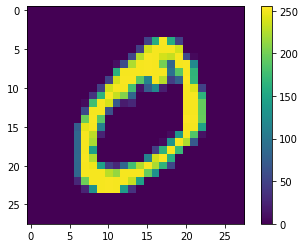

In [914]:
# visualize each image
def showTensor(aTensor):
    plt.figure()
    plt.imshow(aTensor.numpy())
    plt.colorbar()
    plt.show()
    
showTensor(trainset.data[0])   

In [915]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, 
                               kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, 
                               kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=50*4*4, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
    def forward(self, x):
        x = F.relu(self.conv1(x.float()))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x)) #do we need to convert to float here as well?
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [916]:
model_1 = Net()
#compressor(model_1, 0.2)

In [917]:
#print(model_1.conv1.weight_mask)

In [918]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [919]:
net = model_1.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [920]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [921]:
def train(net, train_data, optimizer):
    start = time.time()
    for epoch in range(1): # no. of epochs!!!!!!!!
        running_loss = 0.0
        for i, data in enumerate(train_data, 0):
            # data pixels and labels to GPU if available
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            # set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # propagate the loss backward
            loss.backward()
            optimizer.step()
            # print for mini batches
            running_loss += loss.item()
            if i % 1000 == 999:  # every 1000 mini batches
                print('[Epoch %d, %5d Mini Batches] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss/1000))
                running_loss = 0.0
    end = time.time()
    print('Done Training')
    print('%0.2f minutes' %((end - start) / 60))
    
train(net, trainloader, optimizer)

[Epoch 1,  1000 Mini Batches] loss: 0.898
[Epoch 1,  2000 Mini Batches] loss: 0.221
[Epoch 1,  3000 Mini Batches] loss: 0.150
[Epoch 1,  4000 Mini Batches] loss: 0.127
[Epoch 1,  5000 Mini Batches] loss: 0.101
[Epoch 1,  6000 Mini Batches] loss: 0.086
[Epoch 1,  7000 Mini Batches] loss: 0.082
[Epoch 1,  8000 Mini Batches] loss: 0.074
[Epoch 1,  9000 Mini Batches] loss: 0.090
[Epoch 1, 10000 Mini Batches] loss: 0.065
[Epoch 1, 11000 Mini Batches] loss: 0.060
[Epoch 1, 12000 Mini Batches] loss: 0.066
[Epoch 1, 13000 Mini Batches] loss: 0.052
[Epoch 1, 14000 Mini Batches] loss: 0.055
[Epoch 1, 15000 Mini Batches] loss: 0.056
Done Training
1.58 minutes


In [922]:
print(net.conv1.weight.size())

torch.Size([20, 1, 5, 5])


In [923]:
net.conv1.weight

Parameter containing:
tensor([[[[-0.0631, -0.0434, -0.0322, -0.1848,  0.2348],
          [ 0.0392, -0.1756, -0.0527,  0.0816,  0.1513],
          [ 0.1049, -0.1922,  0.2122, -0.1849, -0.1316],
          [ 0.2238,  0.0304,  0.2147, -0.0231, -0.2041],
          [-0.0438,  0.0251,  0.1054, -0.1326, -0.0197]]],


        [[[ 0.0700,  0.2463, -0.1869, -0.2587, -0.2072],
          [ 0.0689,  0.1919,  0.2239, -0.1451, -0.3733],
          [-0.1195,  0.2283,  0.5042,  0.2202, -0.2375],
          [-0.1791, -0.0886,  0.3388,  0.3580,  0.0849],
          [-0.1794, -0.2106,  0.0807, -0.0902,  0.1454]]],


        [[[ 0.0824,  0.2138,  0.1598,  0.0342,  0.0775],
          [ 0.1746,  0.1864,  0.1585,  0.3540,  0.2186],
          [-0.1090, -0.0339,  0.0691, -0.0036,  0.1188],
          [-0.1496, -0.2535, -0.0168, -0.1987,  0.1627],
          [-0.2880, -0.2172, -0.1835, -0.1985, -0.2126]]],


        [[[-0.0990, -0.1784,  0.2339,  0.1477,  0.0573],
          [-0.0335,  0.2854,  0.2565,  0.1000, -0.0840

In [924]:
conv1_weights = net.conv1.weight.detach().numpy()

In [925]:
conv2_weights = net.conv2.weight.detach().numpy()

In [926]:
fc1_weights = net.fc1.weight.detach().numpy()
fc2_weights = net.fc2.weight.detach().numpy()

In [927]:
#conv1_weight_orig = model_1.conv1.weight_orig.detach().numpy()
flattened_conv1_orig = conv1_weights.ravel()
print(flattened_conv1_orig.size)

500


In [928]:
flattened_conv2_orig = conv2_weights.ravel()
print(flattened_conv2_orig.size)

25000


In [929]:
flattened_fc1_orig = fc1_weights.ravel()
flattened_fc2_orig = fc2_weights.ravel()
print(flattened_fc1_orig.size)
print(flattened_fc2_orig.size)

400000
5000


In [930]:
def random_index(max_range, dropout_rate=0.2, random_seed=10): 
    np.random.seed(random_seed)
    random_list = np.random.choice(range(max_range), int(max_range * dropout_rate) , replace=False)
    random_list.sort()
    return random_list

In [985]:
def compression(model, dropout_rate=0.2, random_seed=10):
    compressed_weights = {}
    zero_indices = {}
    for name, m in model.named_children():
        orig_weights = m.weight.detach().numpy()
        #print(orig_weights.shape)
        flattened_orig = orig_weights.ravel()
        random_indices = random_index(flattened_orig.size, dropout_rate=dropout_rate, random_seed=random_seed)
        compressed_flattened_weights = np.delete(flattened_orig, random_indices)
        compressed_weights[name] = {
            'size': flattened_orig.size,
            'shape': orig_weights.shape,
            'weights': compressed_flattened_weights,
            'bias': m.bias
        }
        #print(compressed_flattened_weights.nbytes)
    return compressed_weights
# for layer in m.children():
#     weights = list(layer.parameters())

In [990]:
cw = compression(net, random_seed=123)
print(cw)
torch.save(cw, './model')

{'conv1': {'size': 500, 'shape': (20, 1, 5, 5), 'weights': array([-0.06311929, -0.04336417, -0.03222009, -0.18482783,  0.23477986,
       -0.17557675, -0.05274175,  0.08155678,  0.10492679,  0.21216552,
       -0.1315798 ,  0.03035231,  0.21470737, -0.02308621, -0.20410906,
       -0.04378352,  0.02508779,  0.10536567, -0.13259022,  0.06995094,
       -0.18693781, -0.25869635, -0.20719339,  0.0688824 ,  0.19190998,
        0.22387221, -0.11949172,  0.5042266 ,  0.22017145, -0.23754418,
       -0.17912184,  0.35795048,  0.08493593, -0.17939936, -0.21056058,
        0.0807202 ,  0.08239484,  0.21375096,  0.1598448 ,  0.03419674,
        0.07746512,  0.18642843,  0.1585452 ,  0.35403088, -0.10900239,
       -0.03386626,  0.06910697, -0.00361548,  0.11876479, -0.14956324,
       -0.01676279, -0.19868909,  0.16274281, -0.2880245 , -0.2171544 ,
       -0.19847305, -0.21261367, -0.1783827 ,  0.23390386,  0.14768569,
        0.05732898, -0.03354806,  0.28540045,  0.10003971, -0.08402345,
     

In [987]:
cw['conv1']['bias']

Parameter containing:
tensor([-0.0043, -0.1102,  0.0247,  0.0222, -0.0254,  0.1691,  0.1220, -0.1632,
         0.0741, -0.3533, -0.0546,  0.0616, -0.0791, -0.0884, -0.1745, -0.0998,
         0.2434,  0.2171,  0.1365,  0.0053], requires_grad=True)

In [406]:
print("Size of the array: ", compressed_flattened_conv1_orig.size)
print("Length of one array element in bytes: ", compressed_flattened_conv1_orig.itemsize)
print("Total bytes consumed by the elements of the array: ", compressed_flattened_conv1_orig.nbytes)

Size of the array:  400
Length of one array element in bytes:  4
Total bytes consumed by the elements of the array:  1600


In [407]:
print("Size of the array: ", compressed_flattened_conv1_masked.size)
print("Length of one array element in bytes: ", compressed_flattened_conv1_masked.itemsize)
print("Total bytes consumed by the elements of the array: ", compressed_flattened_conv1_masked.nbytes)

Size of the array:  500
Length of one array element in bytes:  4
Total bytes consumed by the elements of the array:  2000


In [356]:
nonzero_flattened_conv1 = flattened_conv1[flattened_conv1 != 0]
print("Size of the array: ", nonzero_flattened_conv1.size)
print("Length of one array element in bytes: ", nonzero_flattened_conv1.itemsize)
print("Total bytes consumed by the elements of the array: ", nonzero_flattened_conv1.nbytes)


Size of the array:  400
Length of one array element in bytes:  4
Total bytes consumed by the elements of the array:  1600


In [308]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(model_1.conv1.weight == 0))
        / float(model_1.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(model_1.conv2.weight == 0))
        / float(model_1.conv2.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(model_1.fc1.weight == 0))
        / float(model_1.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(model_1.fc2.weight == 0))
        / float(model_1.fc2.weight.nelement())
    )
)

print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model_1.conv1.weight == 0)
            + torch.sum(model_1.conv2.weight == 0)
            + torch.sum(model_1.fc1.weight == 0)
            + torch.sum(model_1.fc2.weight == 0)

        )
        / float(
            model_1.conv1.weight.nelement()
            + model_1.conv2.weight.nelement()
            + model_1.fc1.weight.nelement()
            + model_1.fc2.weight.nelement()

        )
    )
)

Sparsity in conv1.weight: 20.00%
Sparsity in conv2.weight: 20.00%
Sparsity in fc1.weight: 20.00%
Sparsity in fc2.weight: 20.00%
Global sparsity: 20.00%


In [19]:
for param in net.parameters():
     print(param.shape)

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([50, 20, 5, 5])
torch.Size([50])
torch.Size([500, 800])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


In [993]:
correct = 0
total = 0
correct_per_digit = np.zeros(10)
total_per_digit = np.zeros(10)

with torch.no_grad():
    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        
        # net 1
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # compute accuracy per digit label
        for i in range(10):
            total_per_digit[i] += labels.tolist().count(i)
            if i in labels:
                idx = labels.tolist().index(i)
                correct_per_digit[i] += (predicted[idx] == i).sum().item()
            
print('Accuracy of the network on all digits: %0.3f %%' % (100 * correct / total))

for i in range(10):
    print('Accuracy of the network digit %d: %0.3f %%' % (i, 100 * correct_per_digit[i] / total_per_digit[i]))

Accuracy of the network on all digits: 98.450 %
Accuracy of the network digit 0: 87.449 %
Accuracy of the network digit 1: 86.079 %
Accuracy of the network digit 2: 88.081 %
Accuracy of the network digit 3: 87.921 %
Accuracy of the network digit 4: 85.540 %
Accuracy of the network digit 5: 85.987 %
Accuracy of the network digit 6: 88.100 %
Accuracy of the network digit 7: 86.284 %
Accuracy of the network digit 8: 87.372 %
Accuracy of the network digit 9: 84.539 %


In [994]:
print(correct_per_digit)
print(total_per_digit)
print('total trainning batch number: {}'.format(len(trainloader)))

[857. 977. 909. 888. 840. 767. 844. 887. 851. 853.]
[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]
total trainning batch number: 15000
